# 셀 1: 라이브러리 불러오기 및 환경 설정

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import open3d as o3d  # Point cloud visualization 용
import struct
import cv2  # Bilateral filtering 용


In [81]:
# 셀 2: 캘리브레이션 파일 읽기 및 매트릭스 파싱
def parse_calib_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    def parse_line(line, label):
        if line.startswith(label):
            return np.fromstring(line.strip().split(': ')[1], sep=' ')
        return None

    P0 = parse_line(lines[0], 'P0') if len(lines) > 0 else None
    P1 = parse_line(lines[1], 'P1') if len(lines) > 1 else None
    P2 = parse_line(lines[2], 'P2') if len(lines) > 2 else None
    P3 = parse_line(lines[3], 'P3') if len(lines) > 3 else None
    R0_rect = parse_line(lines[4], 'R0_rect') if len(lines) > 4 else None
    Tr_velo_to_cam = parse_line(lines[5], 'Tr_velo_to_cam') if len(lines) > 5 else None
    Tr_imu_to_velo = parse_line(lines[6], 'Tr_imu_to_velo') if len(lines) > 6 else None
    Tr_cam_to_road = parse_line(lines[7], 'Tr_cam_to_road') if len(lines) > 7 else None

    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo, Tr_cam_to_road

# 파일 경로에 맞게 캘리브레이션 데이터 읽기
P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo, Tr_cam_to_road = parse_calib_file('/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_calib/training/calib/000127.txt')
Tr = np.vstack((np.reshape(Tr_velo_to_cam, (3, 4)), [0, 0, 0, 1]))
R0 = np.eye(4)
R0[:3, :3] = np.reshape(R0_rect, (3, 3))
P = np.reshape(P2, (3, 4))


In [98]:
# 셀 3: LiDAR 데이터 읽기 함수 정의 및 데이터 불러오기
def read_velodyne_data(filename):
    points = []
    with open(filename, 'rb') as f:
        while True:
            bytes = f.read(16)
            if len(bytes) < 16:
                break
            x, y, z, intensity = struct.unpack('ffff', bytes)
            points.append([x, y, z, intensity])
    return np.array(points)

# data = read_velodyne_data('/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_velodyne/training/velodyne/000008.bin')

data = read_velodyne_data('/media/ssd3/lab/jojeon/KITTI/data_spoofing/velodyne/train_delete/000127/000127-3.bin')
# data = read_velodyne_data('/media/ssd3/lab/jojeon/KITTI/data_object/velodyne_transformed_empty/000001_transformed_emptybox_1.bin')


In [99]:
# 셀 4: LiDAR 데이터의 분포 범위 확인 
# X, Y, Z 축의 최소/최대 값을 계산하여 범위를 추정
x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])
z_min, z_max = np.min(data[:, 2]), np.max(data[:, 2])

print(f"X 범위: {x_min} ~ {x_max}")
print(f"Y 범위: {y_min} ~ {y_max}")
print(f"Z 범위 (깊이): {z_min} ~ {z_max}")



X 범위: -79.81700134277344 ~ 78.95899963378906
Y 범위: -78.5250015258789 ~ 71.34600067138672
Z 범위 (깊이): -30.482999801635742 ~ 2.9119999408721924


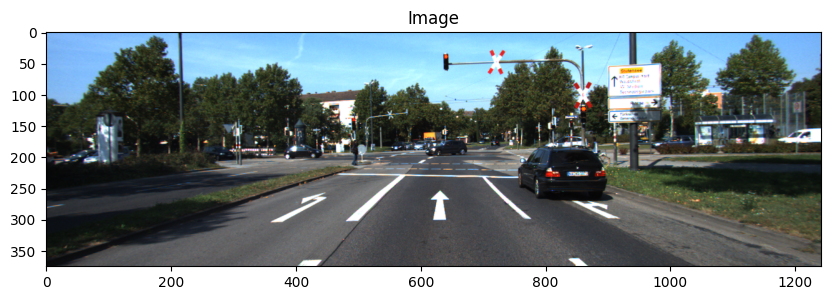

In [100]:
# 셀 5: 이미지 읽기 및 표시
img = Image.open('/media/ssd3/lab/sypark/KITTI/object/2d_object/data_object_image_2/training/image_2/000127.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Image')
plt.show()


In [101]:
# 셀 6: 이미지 상으로 매핑
# x > 5 조건으로 데이터 필터링
filtered_data = data[data[:, 0] > 5]  # x > 5 조건
print(f"Filtered points count: {filtered_data.shape[0]}")


img_h, img_w = img.size[1], img.size[0]

# Homogeneous 좌표로 변환
XYZ1 = np.vstack((filtered_data[:, :3].T, np.ones(filtered_data.shape[0])))

xy1 = P @ (R0 @ Tr @ XYZ1)
s = xy1[2, :]
u = (xy1[0, :] / s).astype(int) #픽셀 x좌표
v = (xy1[1, :] / s).astype(int) #y좌표

valid_indices = (s > 0) & (0 <= u) & (u < img_w) & (0 <= v) & (v < img_h)
u = u[valid_indices]
v = v[valid_indices]
valid_depth = s[valid_indices]  # 깊이 값
valid_intensity = filtered_data[valid_indices, 3]  # 반사율 값
print(f"Valid pixel points count: {len(u)}")


Filtered points count: 34478
Valid pixel points count: 17768


Depth Range: Min = 5.631788619096759, Max = 78.7163925193402


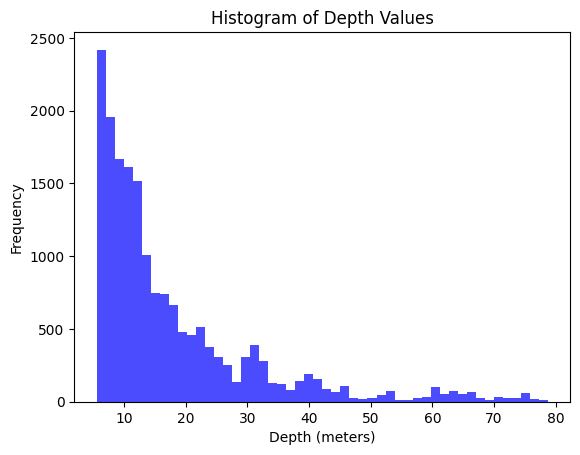

In [102]:
####깊이값 분포확인하기
print(f"Depth Range: Min = {valid_depth.min()}, Max = {valid_depth.max()}")
plt.hist(valid_depth, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Depth Values")
plt.xlabel("Depth (meters)")
plt.ylabel("Frequency")
plt.show()


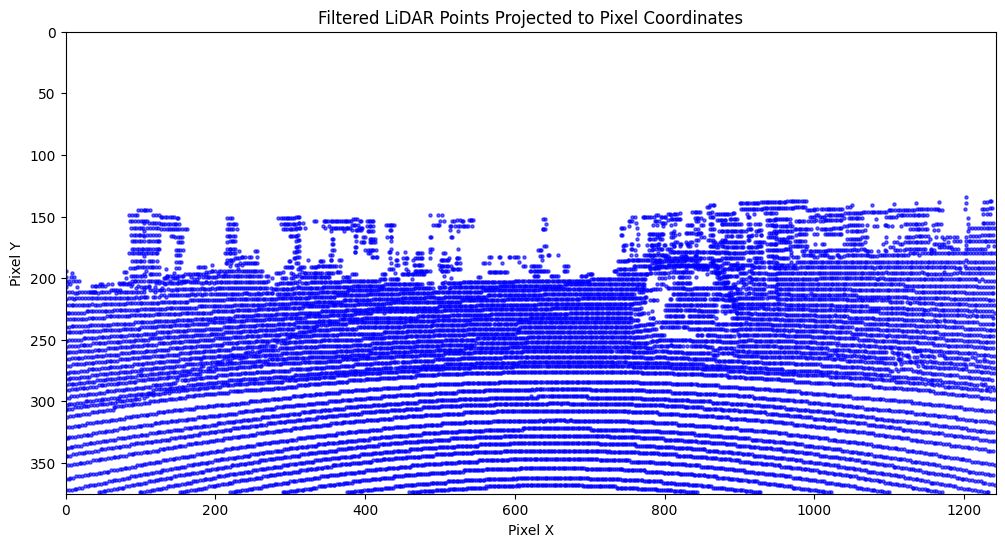

In [103]:
# 셀 7: 이미지에 매핑하여 포인트 클라우드 강조하기
# 필터링된 픽셀 좌표 시각화
plt.figure(figsize=(12, 6))
plt.scatter(u, v, c='blue', s=5, alpha=0.6)  # 포인트 크기는 s로 조정
plt.gca().invert_yaxis()  # 이미지 좌표계에 맞게 Y축 반전
plt.title('Filtered LiDAR Points Projected to Pixel Coordinates')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.xlim(0, img_w)
plt.ylim(img_h, 0)
plt.show()


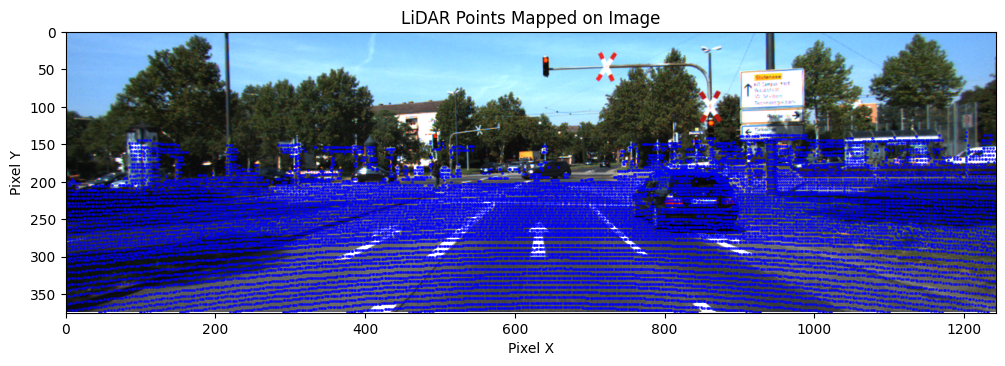

In [104]:
# 이미지 위에 LiDAR 포인트 클라우드를 매핑 (Y축 뒤집기 수정)
plt.figure(figsize=(12, 6))

# 이미지 배경 표시
plt.imshow(img)

# LiDAR 포인트를 이미지 위에 매핑
plt.scatter(u, v, c='blue', s=5, alpha=0.6, marker='.')  # 파란색 점으로 표시

# 타이틀 및 축 설정
plt.title('LiDAR Points Mapped on Image')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# 이미지 좌표계에 맞게 Y축 범위를 조정
plt.xlim(0, img_w)
plt.ylim(img_h, 0)  # Y축을 이미지 좌표계와 일치시킴

plt.show()


셀 8: 깊이 맵 생성 및 컬러맵 범위 고정

Depth Map: Min = 5.631788619096759, Max = 78.7163925193402


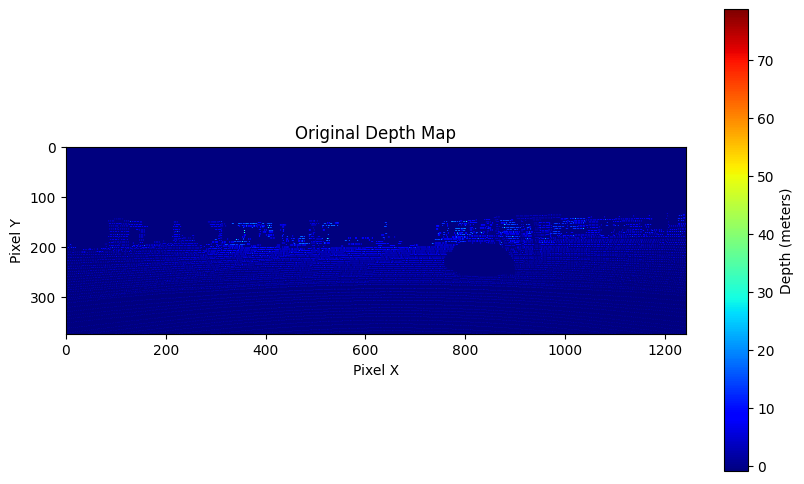

In [89]:
# 깊이 맵 초기화
depth_map = np.full((img_h, img_w), -1, dtype=float)

# 깊이 값 맵핑 (이미지 좌표로 변환된 포인트 기준)
for i in range(len(u)):
    depth_map[v[i], u[i]] = valid_depth[i]

# 깊이 맵의 최소값과 최대값 출력
print(f"Depth Map: Min = {np.min(valid_depth)}, Max = {np.max(valid_depth)}")

# 생성된 깊이 맵 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map, cmap='jet')
plt.colorbar(label='Depth (meters)')
plt.title('Original Depth Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


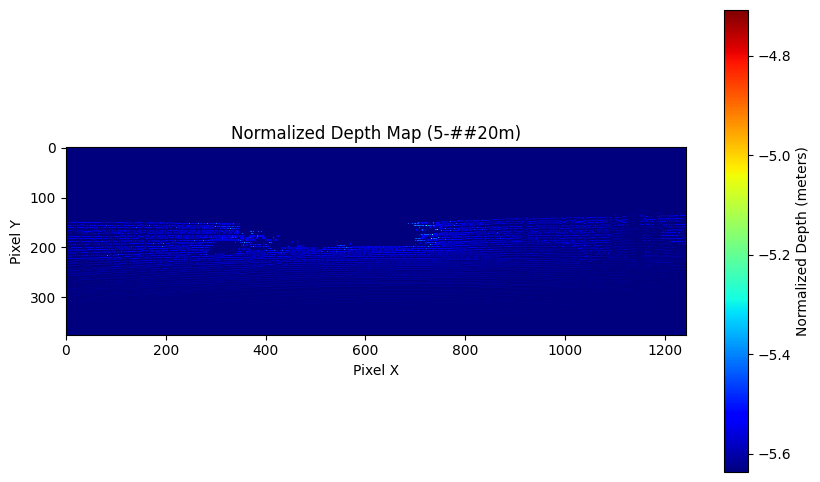

In [71]:

depth_map_normalized = np.clip(depth_map, np.min(valid_depth), np.max(valid_depth))  # 10~20m 값 제한
depth_map_normalized = (depth_map_normalized - np.min(valid_depth)) / np.max(valid_depth) - np.min(valid_depth)  # 0~1로 정규화

# 정규화된 깊이 맵 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map_normalized, cmap='jet')
plt.colorbar(label='Normalized Depth (meters)')
plt.title('Normalized Depth Map (5-##20m)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


/home/jojeon/nu37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log1p
  
/home/jojeon/nu37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/home/jojeon/nu37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


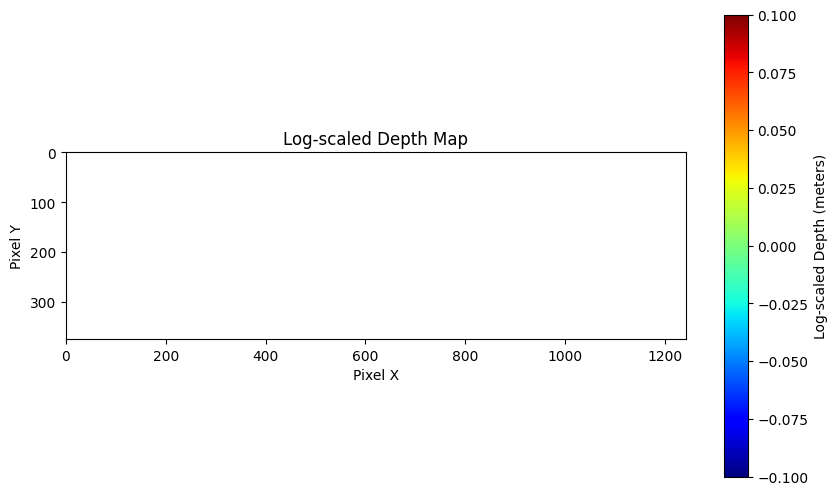

In [35]:
# 로그 변환 적용
depth_map_log = np.log1p(depth_map)  # log(1+x) 변환으로 값 압축

# 로그 스케일로 정규화
depth_map_log_normalized = (depth_map_log - np.min(depth_map_log)) / (np.max(depth_map_log) - np.min(depth_map_log))

# 로그 스케일 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map_log_normalized, cmap='jet')
plt.colorbar(label='Log-scaled Depth (meters)')
plt.title('Log-scaled Depth Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


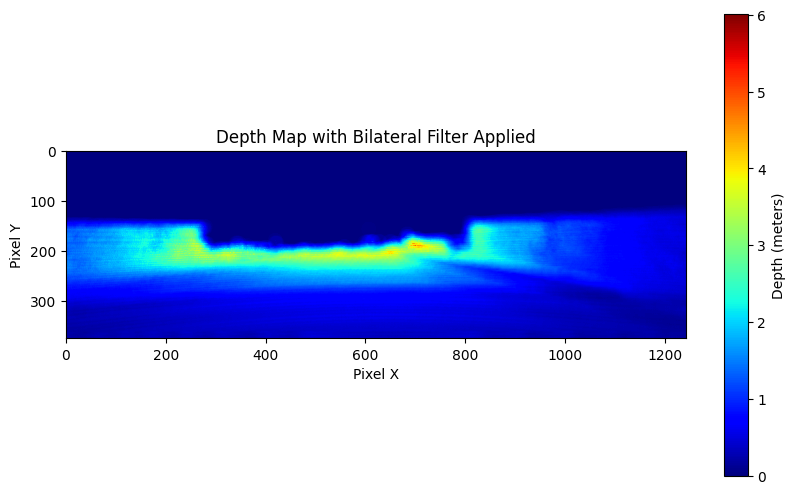

In [36]:
# 결측값(-1)을 0으로 대체 (양방향 필터 적용을 위해)
depth_map_filtered_input = np.where(depth_map == -1, 0, depth_map).astype(np.float32)

# 양방향 필터 적용
d = 30  # 필터 지름
sigmaColor = 75  # 색상 필터의 시그마 값
sigmaSpace = 150  # 좌표 공간 필터의 시그마 값
depth_map_filtered = cv2.bilateralFilter(depth_map_filtered_input, d, sigmaColor, sigmaSpace)

# 양방향 필터 적용된 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map_filtered, cmap='jet')
plt.colorbar(label='Depth (meters)')
plt.title('Depth Map with Bilateral Filter Applied')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()



단순 깊이맵 + 양방향필터


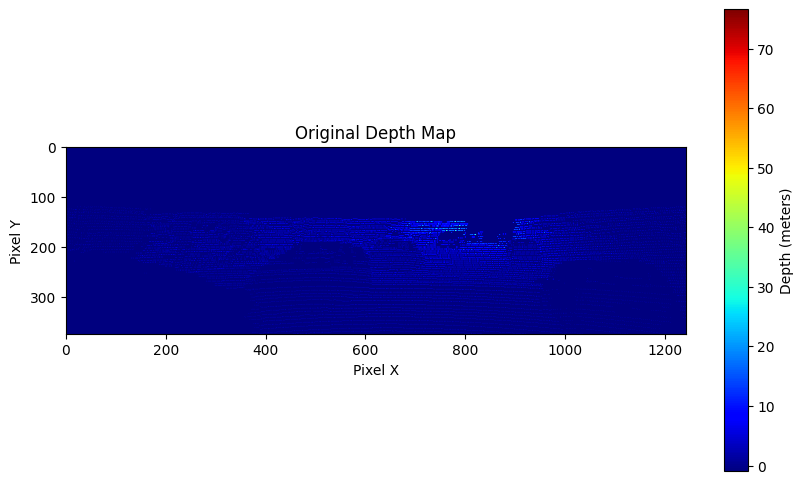

In [15]:
# 깊이 맵 초기화
depth_map = np.full((img_h, img_w), -1, dtype=float)

# 깊이 값 맵핑 (이미지 좌표로 변환된 포인트 기준)
for i in range(len(u)):
    depth_map[v[i], u[i]] = valid_depth[i]  # 깊이 값을 픽셀 좌표에 할당

# 생성된 깊이 맵 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map, cmap='jet')
plt.colorbar(label='Depth (meters)')
plt.title('Original Depth Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


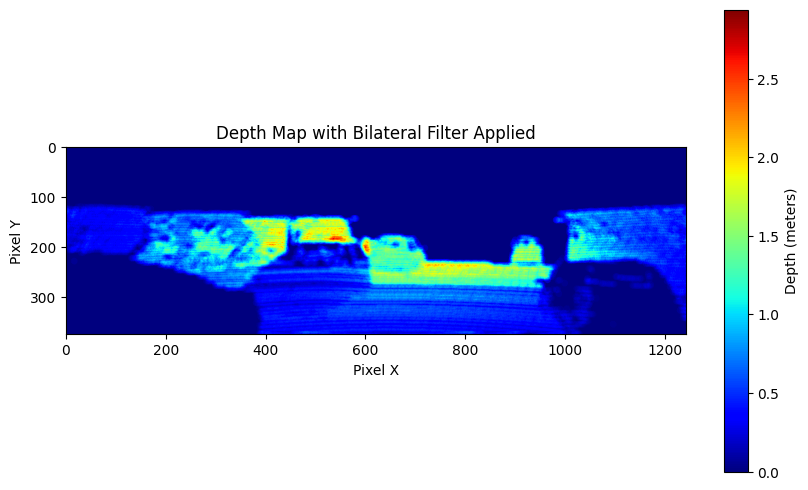

In [64]:
# 결측값(-1)을 0으로 대체 (양방향 필터 적용을 위해)
depth_map_filtered_input = np.where(depth_map == -1, 0, depth_map).astype(np.float32)

# 양방향 필터 적용
d = 15  # 필터 지름
sigmaColor = 75  # 색상 필터의 시그마 값
sigmaSpace = 150  # 좌표 공간 필터의 시그마 값
depth_map_filtered = cv2.bilateralFilter(depth_map_filtered_input, d, sigmaColor, sigmaSpace)

# 양방향 필터 적용된 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(depth_map_filtered, cmap='jet')
plt.colorbar(label='Depth (meters)')
plt.title('Depth Map with Bilateral Filter Applied')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


Intensity값 추가

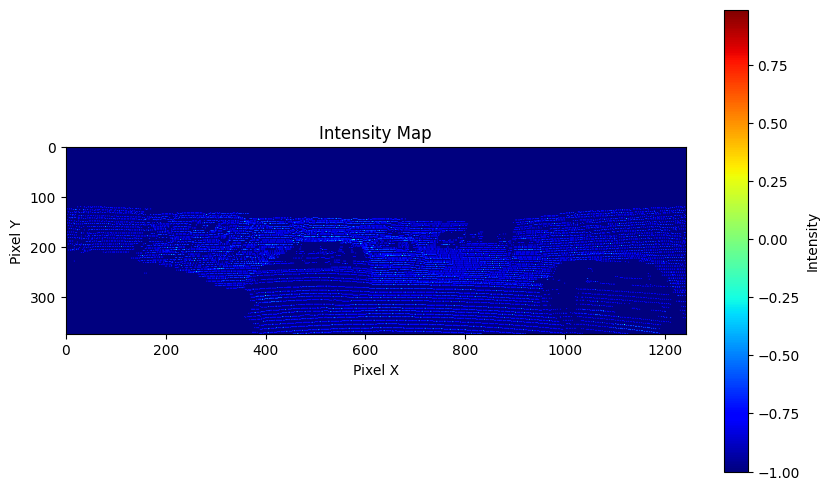

In [ ]:
# 셀 10: Intensity 맵 생성
# 이미지 크기에 맞춰 Intensity 데이터를 2D 맵 형태로 변환하여 시각화
intensity_map = np.full((img_h, img_w), -1, dtype=float)

# 반사율 값 맵핑 (이미지 좌표로 변환된 포인트 기준)
for i in range(len(u)):
    intensity_map[v[i], u[i]] = valid_intensity[i]  # LiDAR 반사율 값 삽입

# 반사율 맵 시각화
plt.figure(figsize=(10, 6))
plt.imshow(intensity_map, cmap='jet')
plt.colorbar(label='Intensity')
plt.title('Intensity Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


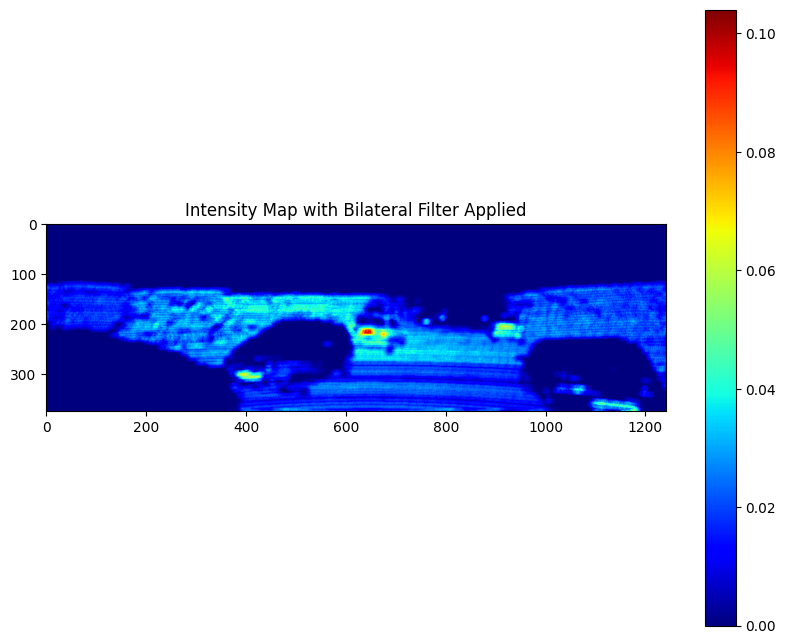

In [65]:
# 셀 11: Intensity 맵에 양방향 필터 적용
# intensity_map에서 결측값(-1)을 0으로 대체하여 양방향 필터를 적용

intensity_map_filtered = np.where(intensity_map == -1, 0, intensity_map).astype(np.float32)

# 양방향 필터 적용
d = 15  # 필터 크기
sigmaColor = 150  # 색상 공간에서 필터의 시그마 값
sigmaSpace = 150  # 좌표 공간에서 필터의 시그마 값
intensity_map_filtered = cv2.bilateralFilter(intensity_map_filtered, d, sigmaColor, sigmaSpace)

# 필터링 후 결과 시각화
plt.figure(figsize=(10, 8))
plt.imshow(intensity_map_filtered, cmap='jet')
plt.colorbar()
plt.title("Intensity Map with Bilateral Filter Applied")
plt.show()
